# Imports

In [ ]:
!pip3 install -q soundFile
!pip3 install -q git+https://github.com/vasudevgupta7/gsoc-wav2vec2@main

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from keras.layers import Dense, Dropout, Input, Flatten
from keras.callbacks import EarlyStopping
from keras import Model
import pandas as pd
import numpy as np
import os
import scipy.io.wavfile as wavfile
from matplotlib import pyplot as plt
from IPython import display
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import soundfile as sf
from wav2vec2 import Wav2Vec2Processor

# Hyper Params

In [ ]:
classes = ['fru', 'ang', 'sad', 'hap']

REQUIRED_SAMPLE_RATE = 16000
LABEL_MAXLEN = 4
BATCH_SIZE =  4


LEARNING_RATE = 5e-6

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss_func = "categorical_crossentropy"
patience = 10
callbacks = [EarlyStopping(monitor="val_accuracy", patience=patience, restore_best_weights=True)]


# Model

In [ ]:
def get_model():
    pretrained_layer = hub.KerasLayer("https://tfhub.dev/vasudevgupta7/wav2vec2/1", trainable=True)

    audio_input = tf.keras.Input(shape=(x_audio_train[0].shape[0],))
    hidden_states = pretrained_layer(audio_input)
    hidden_drop = tf.keras.layers.Dropout(0.2)(hidden_states)
    fc1 = tf.keras.layers.Dense(512,activation = "relu")(hidden_drop)
    fc1_drop = tf.keras.layers.Dropout(0.2)(fc1)
    fc2 = tf.keras.layers.Dense(256,activation = "relu")(fc1_drop)
    avg = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")(fc2)


    bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", trainable=True)
    bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",trainable=True)
    input_text = Input(shape=(), dtype=tf.string, name='text_input')
    text_preprocess = bert_preprocess(input_text)
    outputs_bert = bert_encoder(text_preprocess)
    dense_1 = Dense(512,activation = "relu")(outputs_bert['pooled_output'])
    dense_2 = Dense(256,activation='relu')(dense_1)

    concat = keras.layers.Concatenate()([dense_2,avg])
    fc1 = Dense(128,activation='relu')(concat)
    fc2 = Dense(len(classes),activation='softmax')(fc1)

    model = Model(inputs=[audio_input,input_text],outputs=fc2)
    model.summary()
    return model

# Audio Processing

In [ ]:
def read_wav_file(file_path):
  with open(file_path, "rb") as f:
      audio, sample_rate = sf.read(f)
  if sample_rate != REQUIRED_SAMPLE_RATE:
      raise ValueError(
          f"sample rate (={sample_rate}) of your files must be {REQUIRED_SAMPLE_RATE}"
      )
  file_id = os.path.split(file_path)[-1][:-len(".wav")]
  return audio

In [ ]:
processor = Wav2Vec2Processor(is_tokenizer=False)

def preprocess_speech(audio):
  audio = tf.constant(audio, dtype=tf.float32)
  return processor(tf.transpose(audio))

In [ ]:
def add_padding(wavform, length_in_seconds=15.375):
    input_len = int(REQUIRED_SAMPLE_RATE * length_in_seconds)
    wavform = wavform[:input_len]
    zero_padding = tf.zeros(
        [input_len] - tf.shape(wavform),
        dtype=tf.float32
    )
    wavform = tf.cast(wavform, dtype=tf.float32)
    equal_length = tf.concat([wavform, zero_padding], 0)
    return equal_length

In [ ]:
def convert_audio_path_to_vec(audio_list: list):
    res = audio_list.copy()
    res = list(
        map(
            lambda path: read_wav_file(path),
            res
        )
    )
    res = list(
        map(
            lambda wav: preprocess_speech(wav),
            res
        )
    )
    res = list(
        map(
            lambda vec: add_padding(wavform=vec),
            res
        )
    )
    res = np.array(res)
    return res

# Data Functions

In [ ]:
def calc_distribution(labels, data_name = ""):
    counter = {}
    for i in range(len(classes)):
        counter[i] = 0
    for label in labels:
        idx = np.argmax(label, axis=-1)
        counter[idx] += 1
    res = f"{data_name} Data Has {len(labels)} Samples: "
    for classIdx in counter:
        res += f"Class {classes[classIdx]} has {counter[classIdx]} samples"
        if classIdx == len(classes) - 1:
            res += "."
        else:
            res += ", "
    print(res + "\n")
    return counter

In [ ]:
df = pd.read_csv('../Data/textVideoClassification.tsv',sep='\t')
def get_data(ses_num):
    x_text_train,x_text_val = [],[]
    x_audio_train,x_audio_val = [],[]
    y_train,y_val = [],[]

    for i, row in df.iterrows():
        text = row['text']
        audio_path = os.path.join('../Data','Audio',row['session'],'{}-{}.wav'.format(row['audio'],row['label']))
        label =  np.array(
            [float(row['label']=='fru'),float(row['label']=='ang'),float(row['label']=='sad'),float(row['label']=='hap' or row['label']=='exc')]
        )
        if row['session'] == f'Ses0{ses_num}':
            x_text_val.append(text)
            x_audio_val.append(audio_path)
            y_val.append(label)
        else:
            x_text_train.append(text)
            x_audio_train.append(audio_path)
            y_train.append(label)
    x_text_train = np.array(x_text_train)
    x_text_val = np.array(x_text_val)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    x_audio_train = convert_audio_path_to_vec(x_audio_train)
    x_audio_val = convert_audio_path_to_vec(x_audio_val)

    return {
        'x_text_train': x_text_train,
        'x_text_val': x_text_val,
        'x_audio_train': x_audio_train,
        'x_audio_val': x_audio_val,
        'y_train': y_train,
        'y_val': y_val
    }


In [ ]:
def get_class_weight(distributions):
    weights = dict()
    sum = 0
    for class_idx in distributions:
            sum += distributions[class_idx]

    for class_idx in distributions:
        weights[class_idx] = sum/ (len(classes)* distributions[class_idx])

    return weights

# Experiment 1

In [ ]:
ses_num = 1
data = get_data(ses_num=ses_num)
x_text_train, x_text_val = data['x_text_train'], data['x_text_val']
x_audio_train, x_audio_val = data['x_audio_train'], data['x_audio_val']
y_train, y_val = data['y_train'], data['y_val']

dist = calc_distribution(y_train)
class_weights = get_class_weight(dist)

print(class_weights)

 Data Has 4691 Samples: Class fru has 1569 samples, Class ang has 874 samples, Class sad has 890 samples, Class hap has 1358 samples.

{0: 0.7474506054811982, 1: 1.3418192219679634, 2: 1.317696629213483, 3: 0.8635861561119293}


In [ ]:
model = get_model()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 246000)]     0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 768, 768)     94371712    ['input_1[0][0]']                
                                                                                                  
 text_input (InputLa

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_func,
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    (x_audio_train,x_text_train),
    y_train,
    epochs=10000,
    validation_data=((x_audio_val,x_text_val),y_val),
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/10000


1173/1173 [==============================] - 430s 347ms/step - loss: 1.0298 - accuracy: 0.5355 - val_loss: 0.8319 - val_accuracy: 0.6595
Epoch 2/10000
1173/1173 [==============================] - 404s 345ms/step - loss: 0.6401 - accuracy: 0.7367 - val_loss: 0.7469 - val_accuracy: 0.6789
Epoch 3/10000
1173/1173 [==============================] - 419s 357ms/step - loss: 0.4581 - accuracy: 0.8197 - val_loss: 0.6198 - val_accuracy: 0.7686
Epoch 4/10000
1173/1173 [==============================] - 419s 357ms/step - loss: 0.3430 - accuracy: 0.8676 - val_loss: 0.6628 - val_accuracy: 0.7666
Epoch 5/10000
1173/1173 [==============================] - 404s 344ms/step - loss: 0.2479 - accuracy: 0.9079 - val_loss: 0.7530 - val_accuracy: 0.7431
Epoch 6/10000
1173/1173 [==============================] - 404s 344ms/step - loss: 0.1951 - accuracy: 0.9275 - val_loss: 0.7590 - val_accuracy: 0.7370
Epoch 7/10000
1173/1173 [==============================] - 404s 344ms/step - loss: 0.1351 - accuracy: 0.9505

### Loss & Accuracy

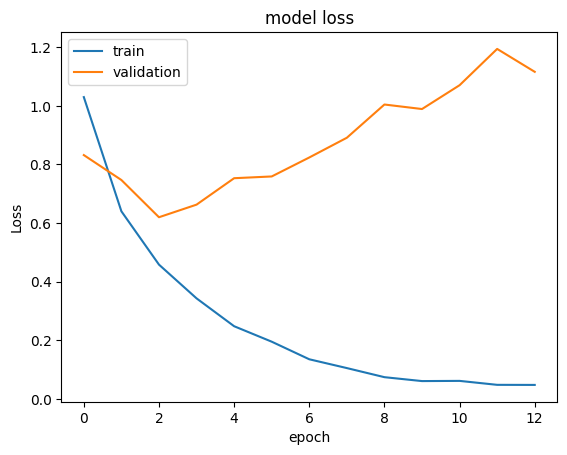

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

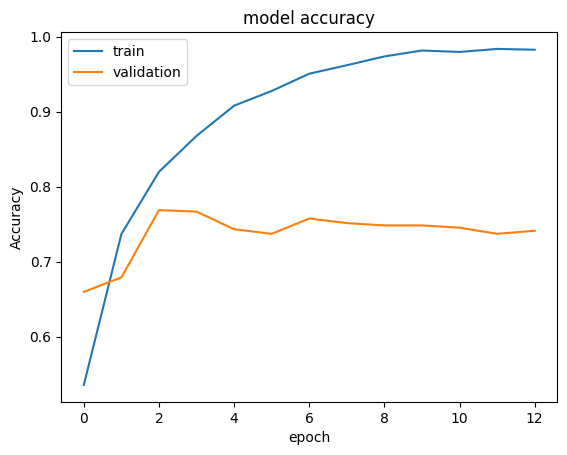

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

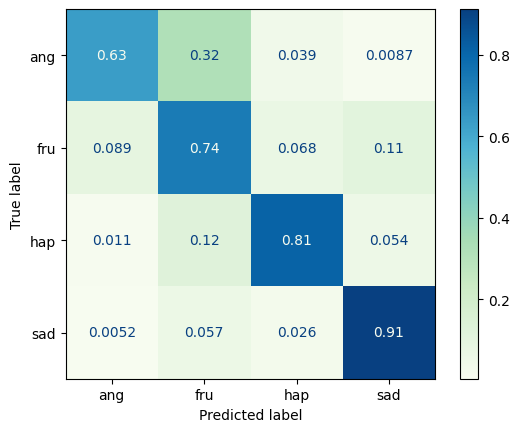

In [ ]:
y_pred = model.predict((x_audio_val,x_text_val))
ConfusionMatrixDisplay.from_predictions(
  list(map(lambda prediction:classes[prediction],y_val.argmax(axis=1))),
  list(map(lambda prediction:classes[prediction],y_pred.argmax(axis=1))),
  normalize='true',cmap='GnBu')
plt.show()

In [ ]:
model.save(f'text+audio-val_Ses0{ses_num}-trainable_all')

INFO:tensorflow:Assets written to: text+audio-val_Ses01-trainable_all/assets


INFO:tensorflow:Assets written to: text+audio-val_Ses01-trainable_all/assets


# Experiment 2

In [ ]:
ses_num = 2
data = get_data(ses_num=ses_num)
x_text_train, x_text_val = data['x_text_train'], data['x_text_val']
x_audio_train, x_audio_val = data['x_audio_train'], data['x_audio_val']
y_train, y_val = data['y_train'], data['y_val']

dist = calc_distribution(y_train)
class_weights = get_class_weight(dist)

print(class_weights)

 Data Has 4686 Samples: Class fru has 1524 samples, Class ang has 966 samples, Class sad has 887 samples, Class hap has 1309 samples.

{0: 0.7687007874015748, 1: 1.2127329192546583, 2: 1.3207440811724915, 3: 0.8949579831932774}


In [ ]:
model = get_model()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 246000)]     0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 768, 768)     94371712    ['input_1[0][0]']                
                                                                                                  
 text_input (InputLa

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_func,
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    (x_audio_train,x_text_train),
    y_train,
    epochs=10000,
    validation_data=((x_audio_val,x_text_val),y_val),
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/10000


1172/1172 [==============================] - 429s 347ms/step - loss: 1.0202 - accuracy: 0.5243 - val_loss: 0.7880 - val_accuracy: 0.6755
Epoch 2/10000
1172/1172 [==============================] - 404s 345ms/step - loss: 0.6478 - accuracy: 0.7283 - val_loss: 0.5853 - val_accuracy: 0.7525
Epoch 3/10000
1172/1172 [==============================] - 404s 345ms/step - loss: 0.4668 - accuracy: 0.8103 - val_loss: 0.5381 - val_accuracy: 0.7931
Epoch 4/10000
1172/1172 [==============================] - 404s 345ms/step - loss: 0.3649 - accuracy: 0.8592 - val_loss: 0.5853 - val_accuracy: 0.7718
Epoch 5/10000
1172/1172 [==============================] - 404s 345ms/step - loss: 0.2904 - accuracy: 0.8918 - val_loss: 0.5811 - val_accuracy: 0.7972
Epoch 6/10000
1172/1172 [==============================] - 404s 344ms/step - loss: 0.2325 - accuracy: 0.9093 - val_loss: 0.6461 - val_accuracy: 0.7748
Epoch 7/10000
1172/1172 [==============================] - 404s 344ms/step - loss: 0.1895 - accuracy: 0.9283

### Loss & Accuracy

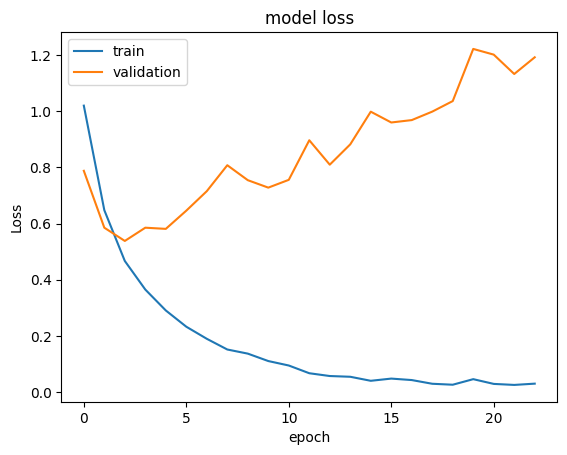

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

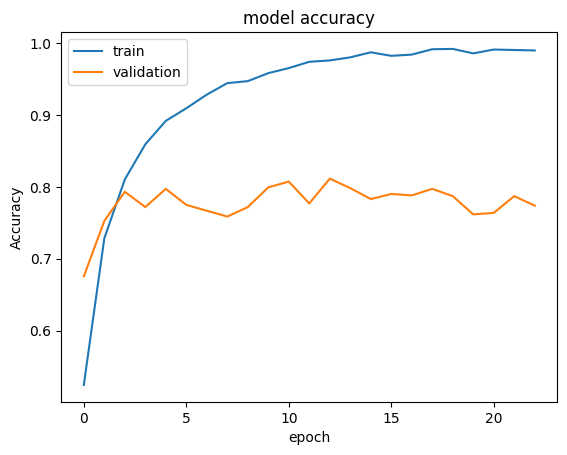

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

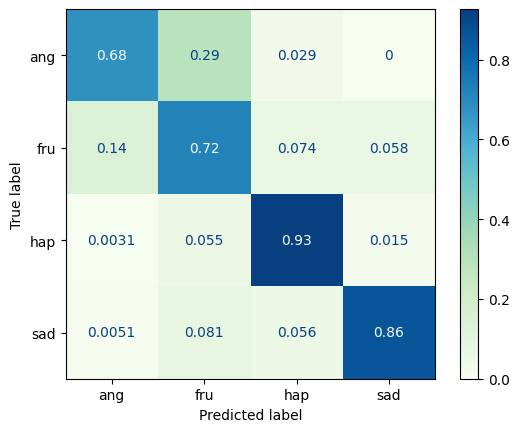

In [ ]:
y_pred = model.predict((x_audio_val,x_text_val))
ConfusionMatrixDisplay.from_predictions(
  list(map(lambda prediction:classes[prediction],y_val.argmax(axis=1))),
  list(map(lambda prediction:classes[prediction],y_pred.argmax(axis=1))),
  normalize='true',cmap='GnBu')
plt.show()

In [ ]:
model.save(f'text+audio-val_Ses0{ses_num}-trainable_all')

INFO:tensorflow:Assets written to: text+audio-val_Ses02-trainable_all/assets


INFO:tensorflow:Assets written to: text+audio-val_Ses02-trainable_all/assets


# Experiment 3

In [ ]:
ses_num = 3
data = get_data(ses_num=ses_num)
x_text_train, x_text_val = data['x_text_train'], data['x_text_val']
x_audio_train, x_audio_val = data['x_audio_train'], data['x_audio_val']
y_train, y_val = data['y_train'], data['y_val']

dist = calc_distribution(y_train)
class_weights = get_class_weight(dist)

print(class_weights)

 Data Has 4459 Samples: Class fru has 1467 samples, Class ang has 863 samples, Class sad has 779 samples, Class hap has 1350 samples.

{0: 0.7598841172460804, 1: 1.2917149478563152, 2: 1.4310012836970476, 3: 0.8257407407407408}


In [ ]:
model = get_model()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 246000)]     0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 768, 768)     94371712    ['input_1[0][0]']                
                                                                                                  
 text_input (InputLa

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_func,
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    (x_audio_train,x_text_train),
    y_train,
    epochs=10000,
    validation_data=((x_audio_val,x_text_val),y_val),
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/10000


1115/1115 [==============================] - 417s 354ms/step - loss: 1.0800 - accuracy: 0.4945 - val_loss: 0.9137 - val_accuracy: 0.6167
Epoch 2/10000
1115/1115 [==============================] - 392s 351ms/step - loss: 0.6498 - accuracy: 0.7192 - val_loss: 0.7589 - val_accuracy: 0.6958
Epoch 3/10000
1115/1115 [==============================] - 392s 351ms/step - loss: 0.4510 - accuracy: 0.8166 - val_loss: 0.7340 - val_accuracy: 0.7082
Epoch 4/10000
1115/1115 [==============================] - 391s 351ms/step - loss: 0.3331 - accuracy: 0.8731 - val_loss: 0.8344 - val_accuracy: 0.6793
Epoch 5/10000
1115/1115 [==============================] - 392s 351ms/step - loss: 0.2498 - accuracy: 0.9036 - val_loss: 0.8311 - val_accuracy: 0.7156
Epoch 6/10000
1115/1115 [==============================] - 392s 351ms/step - loss: 0.1926 - accuracy: 0.9291 - val_loss: 0.9010 - val_accuracy: 0.7189
Epoch 7/10000
1115/1115 [==============================] - 392s 351ms/step - loss: 0.1545 - accuracy: 0.9410

### Loss & Accuracy

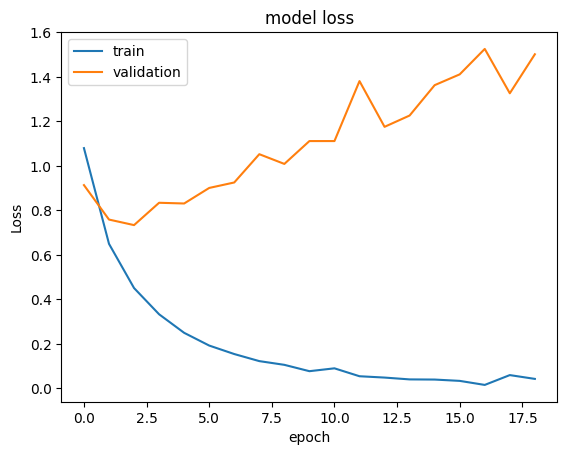

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

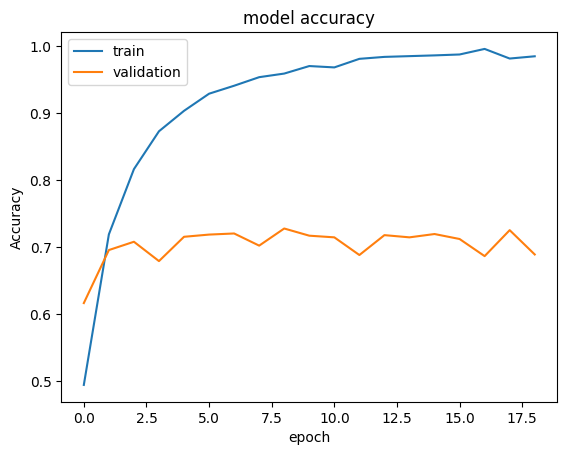

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

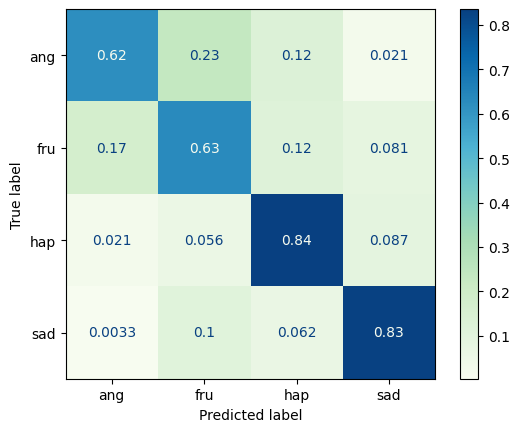

In [ ]:
y_pred = model.predict((x_audio_val,x_text_val))
ConfusionMatrixDisplay.from_predictions(
  list(map(lambda prediction:classes[prediction],y_val.argmax(axis=1))),
  list(map(lambda prediction:classes[prediction],y_pred.argmax(axis=1))),
  normalize='true',cmap='GnBu')
plt.show()

In [ ]:
model.save(f'text+audio-val_Ses0{ses_num}-trainable_all')

INFO:tensorflow:Assets written to: text+audio-val_Ses03-trainable_all/assets


INFO:tensorflow:Assets written to: text+audio-val_Ses03-trainable_all/assets


# Experiment 4

In [ ]:
ses_num = 4
data = get_data(ses_num=ses_num)
x_text_train, x_text_val = data['x_text_train'], data['x_text_val']
x_audio_train, x_audio_val = data['x_audio_train'], data['x_audio_val']
y_train, y_val = data['y_train'], data['y_val']

dist = calc_distribution(y_train)
class_weights = get_class_weight(dist)

print(class_weights)

 Data Has 4418 Samples: Class fru has 1368 samples, Class ang has 776 samples, Class sad has 941 samples, Class hap has 1333 samples.

{0: 0.8073830409356725, 1: 1.4233247422680413, 2: 1.1737513283740701, 3: 0.8285821455363841}


In [ ]:
model = get_model()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 246000)]     0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 768, 768)     94371712    ['input_1[0][0]']                
                                                                                                  
 text_input (InputLa

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_func,
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    (x_audio_train,x_text_train),
    y_train,
    epochs=10000,
    validation_data=((x_audio_val,x_text_val),y_val),
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/10000


1105/1105 [==============================] - 415s 355ms/step - loss: 1.0446 - accuracy: 0.5301 - val_loss: 0.8319 - val_accuracy: 0.6404
Epoch 2/10000
1105/1105 [==============================] - 389s 352ms/step - loss: 0.6407 - accuracy: 0.7347 - val_loss: 0.6906 - val_accuracy: 0.7193
Epoch 3/10000
1105/1105 [==============================] - 390s 353ms/step - loss: 0.4332 - accuracy: 0.8354 - val_loss: 0.6488 - val_accuracy: 0.7488
Epoch 4/10000
1105/1105 [==============================] - 389s 352ms/step - loss: 0.3291 - accuracy: 0.8746 - val_loss: 0.7286 - val_accuracy: 0.7360
Epoch 5/10000
1105/1105 [==============================] - 389s 352ms/step - loss: 0.2355 - accuracy: 0.9129 - val_loss: 0.8568 - val_accuracy: 0.7129
Epoch 6/10000
1105/1105 [==============================] - 389s 352ms/step - loss: 0.1928 - accuracy: 0.9269 - val_loss: 0.7771 - val_accuracy: 0.7424
Epoch 7/10000
1105/1105 [==============================] - 389s 352ms/step - loss: 0.1468 - accuracy: 0.9475

### Loss & Accuracy

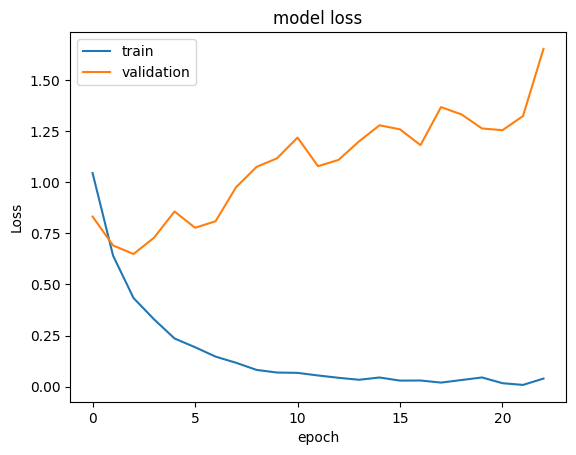

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

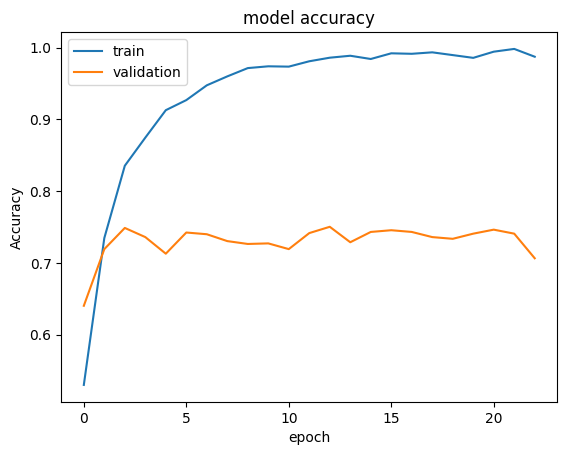

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

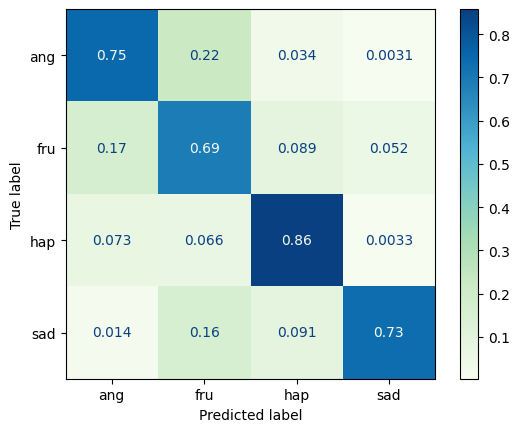

In [ ]:
y_pred = model.predict((x_audio_val,x_text_val))
ConfusionMatrixDisplay.from_predictions(
  list(map(lambda prediction:classes[prediction],y_val.argmax(axis=1))),
  list(map(lambda prediction:classes[prediction],y_pred.argmax(axis=1))),
  normalize='true',cmap='GnBu')
plt.show()

In [ ]:
model.save(f'text+audio-val_Ses0{ses_num}-trainable_all')

INFO:tensorflow:Assets written to: text+audio-val_Ses04-trainable_all/assets


INFO:tensorflow:Assets written to: text+audio-val_Ses04-trainable_all/assets


# Experiment 5

In [ ]:
ses_num = 5
data = get_data(ses_num=ses_num)
x_text_train, x_text_val = data['x_text_train'], data['x_text_val']
x_audio_train, x_audio_val = data['x_audio_train'], data['x_audio_val']
y_train, y_val = data['y_train'], data['y_val']

dist = calc_distribution(y_train)
class_weights = get_class_weight(dist)

print(class_weights)

 Data Has 4434 Samples: Class fru has 1468 samples, Class ang has 933 samples, Class sad has 839 samples, Class hap has 1194 samples.

{0: 0.7551089918256131, 1: 1.1881028938906752, 2: 1.3212157330154946, 3: 0.928391959798995}


In [ ]:
model = get_model()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 246000)]     0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 768, 768)     94371712    ['input_1[0][0]']                
                                                                                                  
 text_input (InputLa

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_func,
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    (x_audio_train,x_text_train),
    y_train,
    epochs=10000,
    validation_data=((x_audio_val,x_text_val),y_val),
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/10000


1109/1109 [==============================] - 415s 355ms/step - loss: 0.9967 - accuracy: 0.5451 - val_loss: 0.8166 - val_accuracy: 0.6656
Epoch 2/10000
1109/1109 [==============================] - 391s 352ms/step - loss: 0.6042 - accuracy: 0.7528 - val_loss: 0.7279 - val_accuracy: 0.7141
Epoch 3/10000
1109/1109 [==============================] - 391s 353ms/step - loss: 0.4219 - accuracy: 0.8295 - val_loss: 0.7209 - val_accuracy: 0.7302
Epoch 4/10000
1109/1109 [==============================] - 391s 353ms/step - loss: 0.2935 - accuracy: 0.8859 - val_loss: 0.7417 - val_accuracy: 0.7496
Epoch 5/10000
1109/1109 [==============================] - 391s 352ms/step - loss: 0.2110 - accuracy: 0.9168 - val_loss: 0.7986 - val_accuracy: 0.7383
Epoch 6/10000
1109/1109 [==============================] - 391s 352ms/step - loss: 0.1488 - accuracy: 0.9425 - val_loss: 0.9878 - val_accuracy: 0.7124
Epoch 7/10000
1109/1109 [==============================] - 399s 360ms/step - loss: 0.1035 - accuracy: 0.9621

### Loss & Accuracy

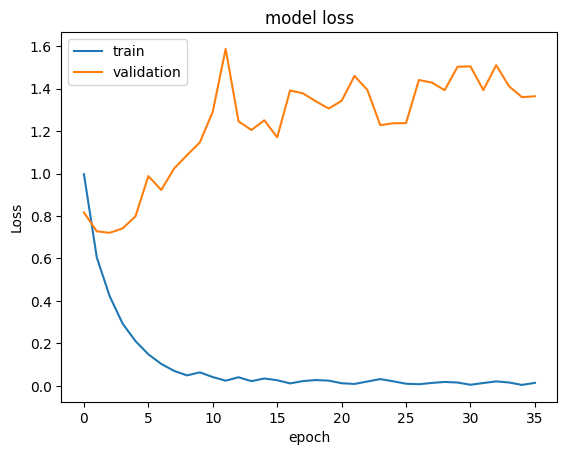

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

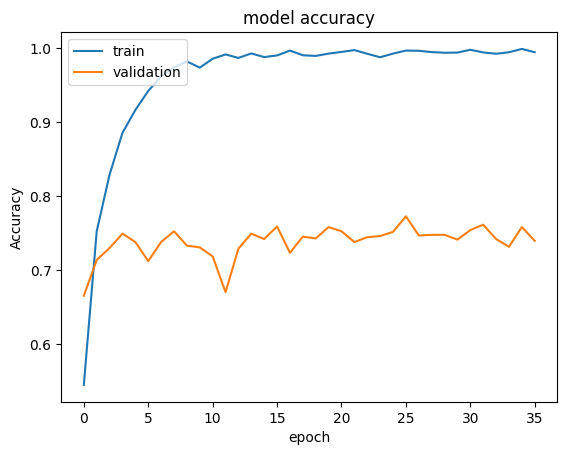

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

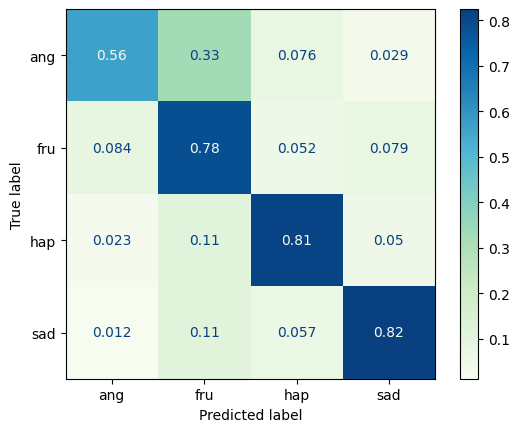

In [ ]:
y_pred = model.predict((x_audio_val,x_text_val))
ConfusionMatrixDisplay.from_predictions(
  list(map(lambda prediction:classes[prediction],y_val.argmax(axis=1))),
  list(map(lambda prediction:classes[prediction],y_pred.argmax(axis=1))),
  normalize='true',cmap='GnBu')
plt.show()

In [ ]:
model.save(f'text+audio-val_Ses0{ses_num}-trainable_all')

INFO:tensorflow:Assets written to: text+audio-val_Ses05-trainable_all/assets


INFO:tensorflow:Assets written to: text+audio-val_Ses05-trainable_all/assets
